# Theory

## Discrete spaces

A discrete space can be defined by a numer of states and their adjacency relationships, this is, which states are accesible from each other. In our case and for practical reasons, this number will be finite, but discrete spaces can have infinite number of states, as continuous spaces can either be confined or unbounded. In addition, we can have a function $f_i$ associated to each state $i$ or more properties. This function in the simplest case, which is what we will be dealing with, will be a scalar e.g. potential energy or fitness. 

Lets see how we can define some simple discrete spaces to illustrate the basis for visualizing functions on complex discrete spaces

In [1]:
# Import required libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import gpmap.src.plot as plot

from gpmap.src.space import GridSpace
from gpmap.src.randwalk import WMWalk

Lets create a simple 2D grid with 20 steps across each of the two dimensions

In [2]:
space = GridSpace(20, ndim=2)
print(space)

Discrete Space:
	Number of states: 400
	State labels: [0-0,0-1,0-2,...,19-17,19-18,19-19]
	States function values: undefined
	Number of edges: 1520.0


And now add some  peaks at certain positions. In the ``nodes_df`` dataframe we have the x,y coordinates of the grid and the associated function at each point of the 2-dimensional grid.

In [3]:
peaks = np.array([[2, 2],
                  [10, 17],
                  [16, 3]])
space.set_peaks(peaks, sigma=7)
ndf, edf = space.nodes_df, space.get_edges_df()
ndf.head()

,1,2,function
0-0,0,0,0.652099
0-1,0,1,0.752238
0-2,0,2,0.867756
0-3,0,3,0.785574
0-4,0,4,0.690295


This space can be most easily represented in 2D because of the nature of the discrete space, so we can directly use our functions for visualizing functions on discrete spaces directly without having to calculate new coordinates

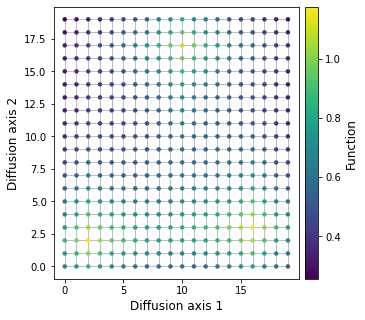

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

plot.plot_visualization(axes, ndf, edges_df=edf,
                        nodes_size=20, edges_alpha=1)

## Evolutionary model

We can define an evolutionary random walk on the graph representing a discrete space (e.g. sequence space). For convenience, we assume a Weak Mutation model of evolution, such that mutations are always fixed or lost before a new mutation arises. In other words, the population is polymorphic in only one site during a specific period of time. 

As we often want to visualize sequence-function relationships rather than direct organismal fitness, we generally assume a linear relationship between function and fitness, controled by the selective coefficient $s$. Given an effective population size of $N$ under uniform mutation rates, the substitution rate is given by

$$
Q_{ij} =
\begin{cases}
    \frac{Ns(f_j - f_i)}{1 - e^{-Ns(f_j - f_i)}} & \text{if i and j are neighbors}\\
    -\sum_{k \neq i} Q_{ik} & \text{if } i=j\\
    0 & \text{otherwise}
\end{cases}
$$

If we obtain the eigendecomposition of $\mathbf{Q}$

$$
\mathbf{Q} = \sum_k \lambda_k r_k l_k^T
$$

We can calculate the transition matrix after some time $t$

$$
P = e^{Qt} = \sum_k e^{\lambda_k t} r_k l_k^T
$$

If we now condition on starting at genotype $i$ and knowing that $r_1 = 1$ and $l_1 = \pi$ and $\lambda_1 = 0$

$$
P_i = \sum_k e^{\lambda_k t} r_{k,i} l_k^T = e^{\lambda_1 t} r_{1,i} l_1^T + \sum_{k\geq2} e^{\lambda_k t} r_{k,i} l_k^T = \pi + \sum_{k\geq2} e^{\lambda_k t} r_{k,i} l_k^T
$$

We can see how the right eigenvectors provide an idea of the weight of the slowly decaying components (small $\lambda$s) depending on the starting genotype.

We can calculate the projection coordinates $u_k$ normalizing the right eigenvectors by the square root of the  decay rate $-\lambda_k$.

$$
u_k = \frac{r_k}{\sqrt{-\lambda_k}}
$$

This way, the sum of square distances in the low dimensional representation approximates the conmute times between every pair of genotypes ($H_{ij} + H_{ji}$) without having to calculate the whole matrix to generate an embedding. 

$$
H_{ij} + H_{ji} = \sum_{k\geq2} (u_{k,j} - u_{k,i})^2
$$

## Intuitive understanding

In practice, as selection strength increases, paths that cross fitness valleys become less and less likely, increasing the time the random walk would need to between different states of the discrete space. Thus, peaks that are isolated from each other will be pushed appart while states separated by many neutral paths will be pulled together in the low dimensional representation. 

Lets see how this happens in our 2D grid landscape

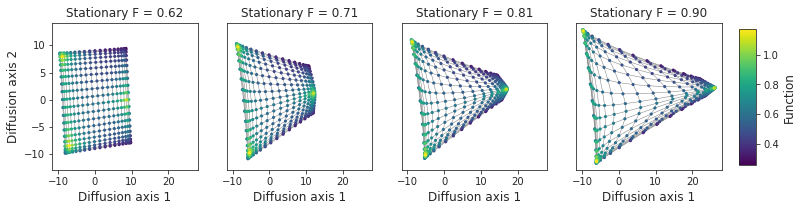

In [5]:
rw = WMWalk(space)
fig = plot.figure_Ns_grid(rw, fmin=0.62, fmax=0.9,
                          nodes_size=10, edges_alpha=1,
                          ascending=True, ncol=4, nrow=1)

With very low selection strength, we can still appreciate the 2-dimensional grid quite accurately, and distances are very close of the simple distances in the graph. However, as we increase the selection strength, we see how the 3 isolated peaks are pulled appart from each other. Interestingly, we can notice that there are 2 of the peaks that are slightly more accessible to each other, since they are separated along diffusion axis 2, while the other peak at the opposite end of the grid is separated from them alon diffusion axis 1, showing that lower accessibility from the other two peaks